In [1]:
import torch
import matplotlib.pyplot as plt
from utils.defects import S_cal
import numpy as np

from kinetic_solver import KineticSolver, KineticData

def _action2light(self, action, grid_size=256):

    x_center = int((action[0]+1)/2 * grid_size)   # 椭圆中心x坐标
    y_center = int((action[1]+1)/2 * grid_size)   # 椭圆中心y坐标
    a = (action[2]+1)/2 * grid_size / 2                # 长轴，假设范围是 [10, 60]
    b = (action[3]+1)/2 * grid_size / 2                # 短轴，假设范围是 [5, 35]
    theta = (action[4]+1)/2 * 2 * np.pi           # 方向角范围 [0, 2π]
    intensity = (action[5]+1)/2 * 100  # 光照强度范围 [1, 6]

    y, x = np.ogrid[:grid_size, :grid_size]
    
    # 3. 旋转椭圆的角度变换
    cos_theta = np.cos(theta)
    sin_theta = np.sin(theta)
    
    # 将坐标平移到椭圆中心
    x_shifted = x - x_center
    y_shifted = y - y_center
    
    # 旋转后的坐标
    x_rotated = x_shifted * cos_theta + y_shifted * sin_theta
    y_rotated = -x_shifted * sin_theta + y_shifted * cos_theta
    
    # 4. 椭圆方程 (x_rotated / a)^2 + (y_rotated / b)^2 <= 1 用于定义椭圆内的区域
    ellipse_mask = (x_rotated / (a + 1e-6))**2 + (y_rotated / (b+ 1e-6))**2 <= 1

    # 5. 创建光照矩阵，初始值都设为1，表示椭圆外部区域
    light_matrix = np.ones((grid_size, grid_size))

    # 6. 渐变效果 - 根据椭圆边缘距离生成，椭圆内从1到1.5渐变
    distance = np.sqrt((x_rotated / (a + 1e-6))**2 + (y_rotated / (b+ 1e-6))**2)
    light_matrix = np.where(ellipse_mask, intensity - (intensity-1) * distance, light_matrix)

    return light_matrix

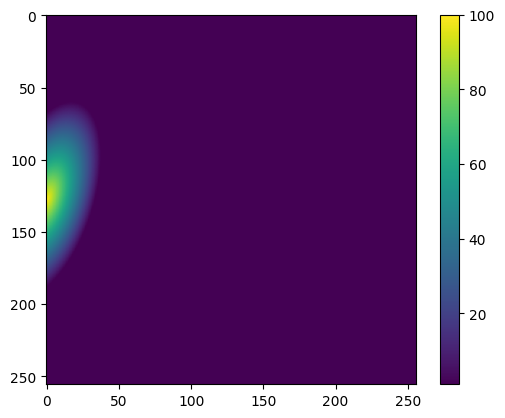

In [3]:
action = (-1, 0, -0.5, 0.1, 0.1, 1)
light_mat = _action2light(None, action, grid_size=256)
import matplotlib.pyplot as plt
plt.imshow(light_mat)
plt.colorbar()
plt.show()

In [16]:
def _action2light(self, action, grid_size=256):

    # 1. 计算椭圆的参数
    x_center = int((action[0] + 1) / 2 * grid_size)  # 椭圆平移后的中心x坐标
    y_center = int((action[1] + 1) / 2 * grid_size)  # 椭圆平移后的中心y坐标
    a = (action[2] + 1) / 2 * grid_size / 2          # 长轴，假设范围是 [10, 60]
    b = (action[3] + 1) / 2 * grid_size / 2          # 短轴，假设范围是 [5, 35]
    theta = (action[4] + 1) / 2 * 2 * np.pi          # 方向角范围 [0, 2π]
    intensity = (action[5] + 1) / 2 * 100            # 光照强度范围 [1, 6]

    # 2. 构建网格坐标，首先以中心为原点放置椭圆
    y, x = np.ogrid[:grid_size, :grid_size]
    x_shifted = x - grid_size // 2  # 椭圆初始位置在中心，平移到正中间
    y_shifted = y - grid_size // 2

    # 3. 旋转椭圆的角度变换
    cos_theta = np.cos(theta)
    sin_theta = np.sin(theta)
    
    # 旋转后的坐标
    x_rotated = x_shifted * cos_theta + y_shifted * sin_theta
    y_rotated = -x_shifted * sin_theta + y_shifted * cos_theta
    
    # 4. 椭圆方程 (x_rotated / a)^2 + (y_rotated / b)^2 <= 1 用于定义椭圆内的区域
    ellipse_mask = (x_rotated / (a + 1e-6))**2 + (y_rotated / (b + 1e-6))**2 <= 1

    # 5. 创建光照矩阵，初始值都设为1，表示椭圆外部区域
    light_matrix = np.ones((grid_size, grid_size))

    # 6. 渐变效果 - 根据椭圆边缘距离生成，椭圆内从1到指定强度渐变
    distance = np.sqrt((x_rotated / (a + 1e-6))**2 + (y_rotated / (b + 1e-6))**2)
    light_matrix_centered = np.where(ellipse_mask, intensity - (intensity - 1) * distance, light_matrix)

    # 7. 将光照矩阵平移到指定的中心位置
    x_translation = (x_center - grid_size // 2) % grid_size
    y_translation = (y_center - grid_size // 2) % grid_size

    # 8. 使用 roll 函数将矩阵平移并处理周期性边界条件
    light_matrix_shifted = np.roll(light_matrix_centered, shift=(y_translation, x_translation), axis=(0, 1))

    return light_matrix_shifted

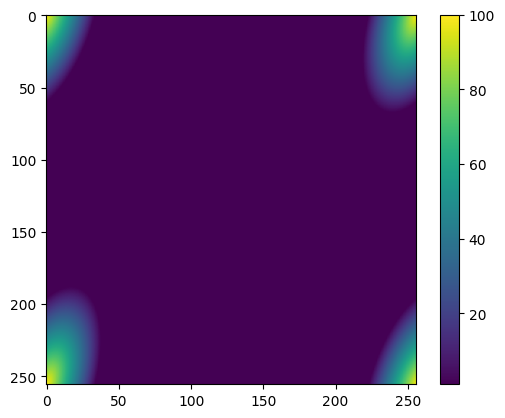

In [19]:
action = (-1, -1, -0.5, 0.1, 0.1, 1)
light_mat = _action2light(None, action, grid_size=256)
import matplotlib.pyplot as plt
plt.imshow(light_mat)
plt.colorbar()
plt.show()

In [1]:
from qqqq import Intensity

[[10, 1], [30, 0]]
[[10, 1], [20, 2], [30, 1], [40, 0]]
[[20, 1], [30, 0], [40, -1], [40.5, 0]]
[[10, -1], [20, 0], [30, -1], [40, -2], [40.5, 0]]


In [20]:
from coding2 import Intensity

In [23]:
a = Intensity()
print(a.get())
a.set(-10, 50, 5)
print(a.get())
# a.set(20, 30, -2)
# print(a.get())
a.set(-11, 100, 0)
print(a.get())

a.set(float('-inf'), float('inf'), 2)
print(a.get())


[]
[[-10, 5], [50, 0]]
[]
[[-inf, 2]]


In [16]:
a = Intensity()
print(a.get())
a.set(-10, 50, 5)
print(a.get())

a.set(-11, 100, 0)
print(a.get())

a.set(float('-inf'), float('inf'), 0)
print(a.get())

[]
[[-10, 5], [50, 0]]
[[-10, 5], [50, 0]]
[]


In [1]:
path = 'test/path'
prefix = 'test'

sum = path + prefix + '.test'

print(sum)

test/pathtest.test
